<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/AP_Torch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is all about discussion on torch Workflow along with an comprehensive study on a Regression Model and a Classification Model.

In [ ]:
# !pip install torchview

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchview import draw_graph

## Torch Workflow fundamentals using a MNIST dataset -- to setup the premise

```md
| Topic                                                    | Contents                                                                                                                          |
|----------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
| 1. Getting data ready                                    | Data can be almost anything but to get started we're going to create a simple straight line                                       |
| 2. Building a model                                      | Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.  |
| 3. Fitting the model to data (training)                  | We've got data and a model, now let's let the model (try to) find patterns in the (training) data.                                |
| 4. Making predictions and evaluating a model (inference) | Our model's found patterns in the data, let's compare its findings to the actual (testing) data.                                  |
| 5. Saving and loading a model                            | You may want to use your model elsewhere, or come back to it later, here we'll cover that.                                        |
|                                                          |                                                                                                                                   |

```

##### Key Pointers:
1. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
2. We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading.
3. nn.Module contains the larger building blocks (layers)
4. nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
5. forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
6. torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

##### Data Loading

In [13]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

In [2]:
# downloading the training data from Datasets library
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 154040597.27it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 104970271.94it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40704939.86it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22598492.01it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
hyper_params = 128
epochs = 10

In [5]:
print(training_data.data.shape)
print(test_data.data.shape)
print(training_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])


In [6]:
# wrapping the raw data into dataloader class
train_loader = DataLoader(training_data, batch_size=hyper_params, shuffle=True)
test_loader = DataLoader(test_data, batch_size=hyper_params, shuffle=True)

In [7]:
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


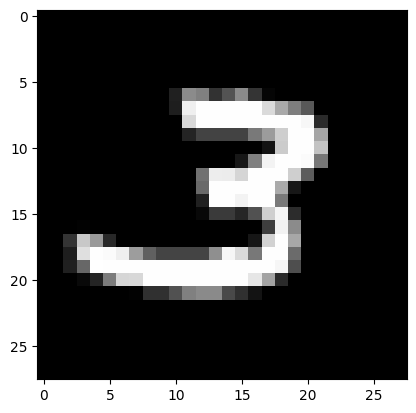

Label: 3


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # Torch.Size([28, 28])
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

##### Model Definition Piece

In [25]:
class SimpleNN(nn.Module):
  """Simple NN model"""
  def __init__(self, input_size, num_classes):
    super(SimpleNN, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x: torch.Tensor):
    x = self.flatten(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return F.log_softmax(x)

In [26]:
model = SimpleNN(input_size=28*28, num_classes=10).to(device)
print(model.state_dict().keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [27]:
# summarization of the model layers
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
            Linear-3                   [-1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


<ipython-input-25-e8af4c1ea3a2>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1386: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


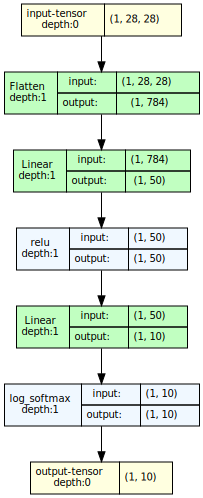

In [28]:
# graphical representation of the model architecture
model_graph = draw_graph(model, input_size=(1, 28, 28), expand_nested=True)
model_graph.visual_graph